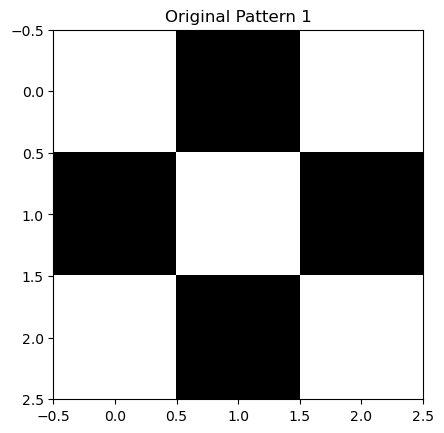

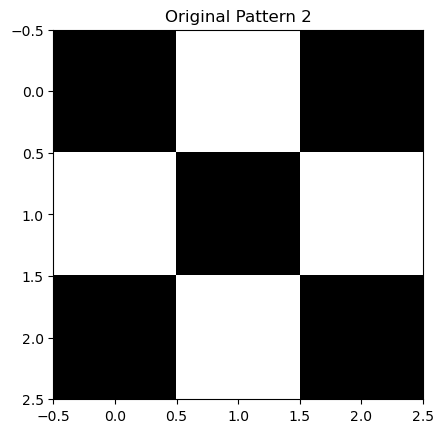

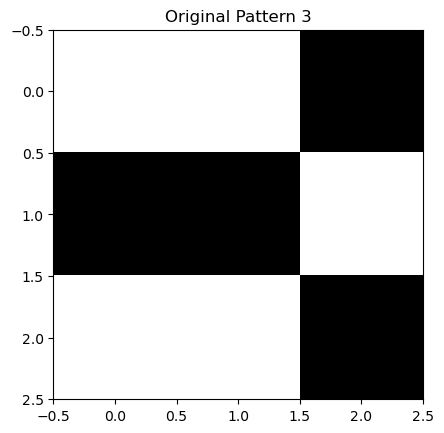

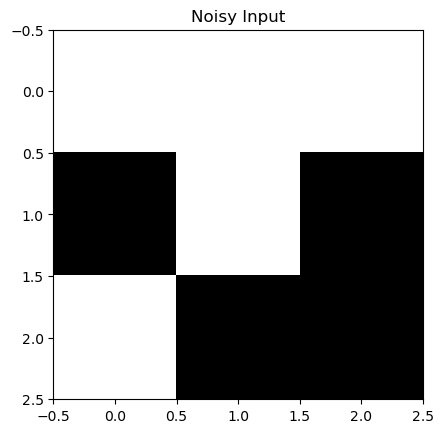

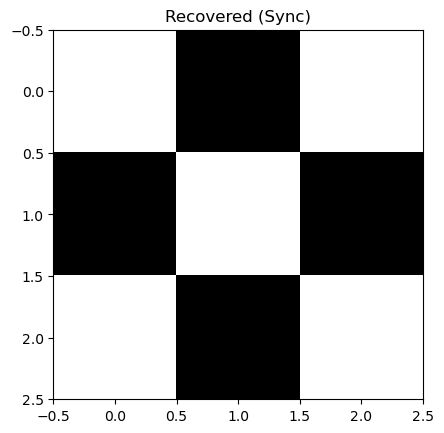

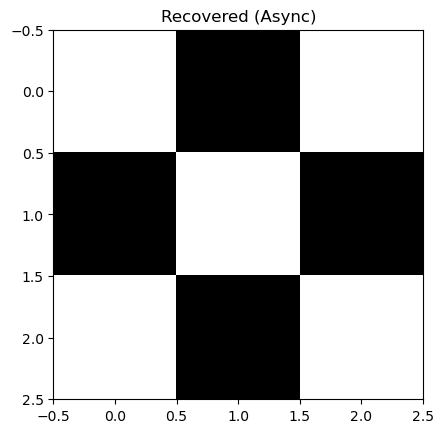

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def generate_patterns():
    # Definujeme binární vzory (-1,1 místo 0,1)
    pattern1 = np.array([[1, -1, 1],
                          [-1, 1, -1],
                          [1, -1, 1]])
    pattern2 = np.array([[-1, 1, -1],
                          [1, -1, 1],
                          [-1, 1, -1]])
    pattern3 = np.array([[1, 1, -1],
                          [-1, -1, 1],
                          [1, 1, -1]])
    
    return [pattern1, pattern2, pattern3]

def binarize(pattern):
    return np.where(pattern > 0, 1, -1)

def vectorize(patterns):
    return [p.flatten() for p in patterns]

def train_hopfield(patterns):
    size = patterns[0].shape[0]  # Počet neuronů
    W = np.zeros((size, size))
    for p in patterns:
        W += np.outer(p, p)  # Maticový součin
    np.fill_diagonal(W, 0)  # Nastavení diagonály na 0
    return W

def update_sync(W, pattern):
    return binarize(np.sign(W @ pattern))

def update_async(W, pattern, steps=5):
    new_pattern = pattern.copy()
    for _ in range(steps):
        for i in range(len(pattern)):
            new_pattern[i] = np.sign(W[i] @ new_pattern)
    return binarize(new_pattern)

# Verze pro animace
def update_async_step(W, pattern, steps=1):
    new_pattern = pattern.copy()
    for _ in range(steps):
        for i in range(len(pattern)):
            new_pattern[i] = np.sign(W[i] @ new_pattern)
    return binarize(new_pattern)

update_sync_step = lambda W, p, steps=1: binarize(np.sign(W @ p))

def add_noise(pattern, noise_level=0.3):
    noisy_pattern = pattern.copy()
    flip_indices = np.random.choice(len(pattern), int(noise_level * len(pattern)), replace=False)
    noisy_pattern[flip_indices] *= -1
    return noisy_pattern

def display_pattern(pattern, title="Pattern"):
    plt.imshow(pattern.reshape(3, 3), cmap='gray')
    plt.title(title)
    plt.show()

# --- TEST ---
patterns = generate_patterns()
vectorized_patterns = vectorize(patterns)
W = train_hopfield(vectorized_patterns)
for i, pattern in enumerate(patterns):
    display_pattern(pattern, f"Original Pattern {i+1}")
test_pattern = add_noise(vectorized_patterns[0], noise_level=0.3)
display_pattern(test_pattern, "Noisy Input")

recovered_pattern_sync = update_sync(W, test_pattern)
display_pattern(recovered_pattern_sync, "Recovered (Sync)")

recovered_pattern_async = update_async(W, test_pattern)
display_pattern(recovered_pattern_async, "Recovered (Async)")


In [24]:
import matplotlib.animation as animation

def energy(W, state):
    """
    Výpočet energie Hopfieldovy sítě pro daný stav.
    """
    return -0.5 * state @ W @ state

# --- Funkce pro animaci + sběr stavů ---
def animate_reconstruction(W, pattern, update_func, steps=10, interval=500, save_as="reconstruction.gif", collect_states=False, resolution= (3, 3)):
    fig, ax = plt.subplots()
    ims = []
    current_pattern = pattern.copy()
    energies = [energy(W, current_pattern)]
    all_states = [current_pattern.copy()]

    for _ in range(steps):
        img = ax.imshow(current_pattern.reshape(resolution[0], resolution[1]), cmap='gray', animated=True)
        ims.append([img])
        current_pattern = update_func(W, current_pattern, steps=1)
        energies.append(energy(W, current_pattern))
        all_states.append(current_pattern.copy())

    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True, repeat_delay=1000)
    ani.save(save_as, writer='pillow')
    plt.close()
    print(f"Animace uložena jako {save_as}")

    plt.figure()
    plt.plot(energies, marker='o')
    plt.title("Vývoj energie")
    plt.xlabel("Krok")
    plt.ylabel("Energie")
    plt.grid(True)
    plt.show()

    if collect_states:
        return all_states
    return None


Animace uložena jako sync.gif


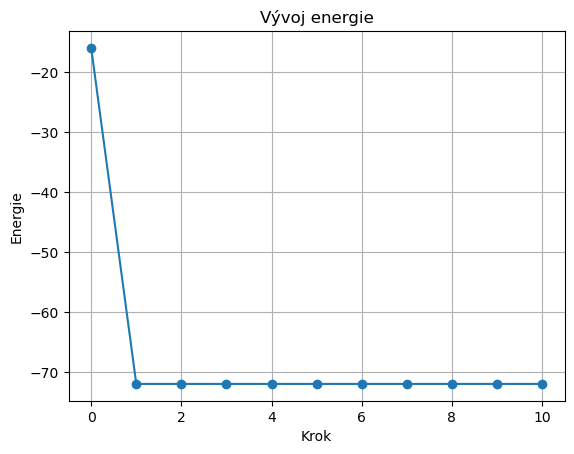

Animace uložena jako async.gif


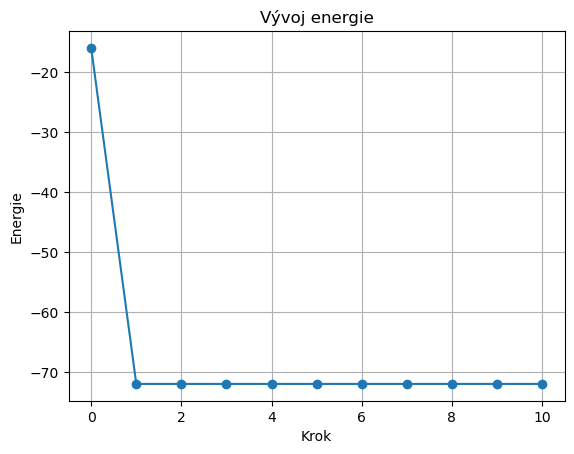

In [15]:
# Zašuměný vzor
noisy = add_noise(vectorized_patterns[1], 0.3)

# Animace synchronní rekonstrukce
animate_reconstruction(W, noisy, update_sync_step, steps=10, save_as="sync.gif")

# Animace asynchronní rekonstrukce
animate_reconstruction(W, noisy, update_async_step, steps=10, save_as="async.gif")

In [20]:
from mpl_toolkits.mplot3d import Axes3D

def plot_energy_trajectory(W, states):
    """
    3D vizualizace vývoje stavu (v prvních 3 neuronech) a energie v čase.
    """
    if len(states[0]) < 3:
        print("Pro 3D vizualizaci je potřeba alespoň 3 neurony.")
        return

    coords = np.array(states)
    energies = [energy(W, s) for s in states]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], marker='o', label='trajektorie')
    ax.scatter(coords[0, 0], coords[0, 1], coords[0, 2], color='green', label='start', s=50)
    ax.scatter(coords[-1, 0], coords[-1, 1], coords[-1, 2], color='red', label='konec', s=50)
    ax.set_xlabel("Neuron 1")
    ax.set_ylabel("Neuron 2")
    ax.set_zlabel("Neuron 3")
    ax.set_title("3D trajektorie stavu sítě")
    ax.legend()
    plt.show()


Animace uložena jako sync.gif


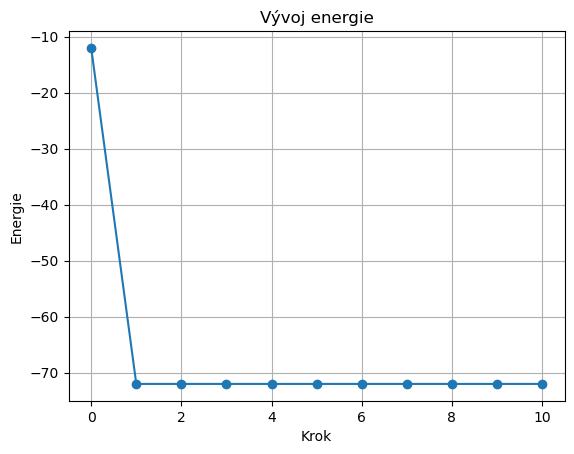

Animace uložena jako async.gif


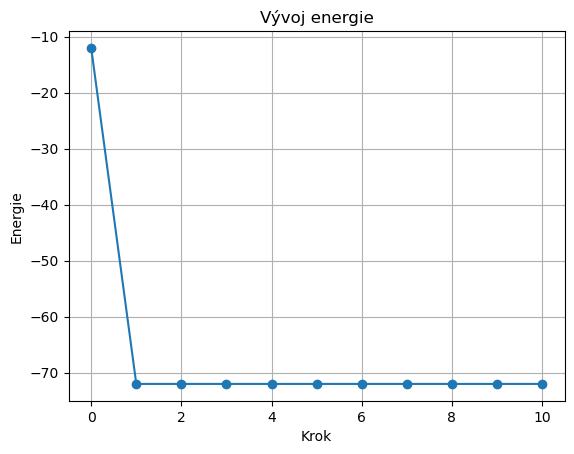

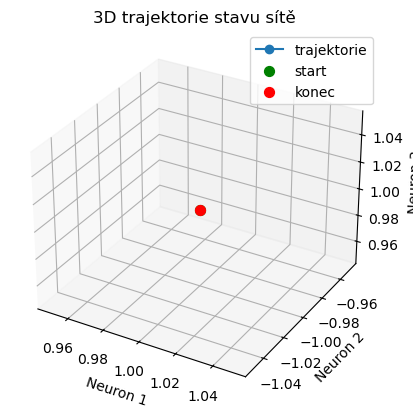

In [32]:
# Generování a trénování
patterns = generate_patterns()
vectorized = vectorize(patterns)
W = train_hopfield(vectorized)

# Zašuměný vstup
test_pattern = add_noise(vectorized[0], noise_level=0.3)

states = animate_reconstruction(W, test_pattern, update_sync_step, steps=10, save_as="sync.gif", collect_states=True)
# Spustíme animaci a získáme mezikroky
states = animate_reconstruction(W, test_pattern, update_async_step, steps=10, save_as="async.gif", collect_states=True)

# Zobrazíme 3D trajektorii
plot_energy_trajectory(W, states)

In [22]:
def generate_patterns_7x7():
    """
    Vytvoří 7x7 binární vzory pro písmena O, A a V.
    Používá hodnoty 1 a -1.
    """
    O = np.array([
        [-1,  1,  1,  1,  1,  1, -1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [-1,  1,  1,  1,  1,  1, -1]
    ])

    A = np.array([
        [-1, -1, -1,  1, -1, -1, -1],
        [-1, -1,  1, -1,  1, -1, -1],
        [-1,  1, -1, -1, -1,  1, -1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1]
    ])

    V = np.array([
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [-1,  1, -1, -1, -1,  1, -1],
        [-1, -1,  1, -1,  1, -1, -1],
        [-1, -1, -1,  1, -1, -1, -1]
    ])

    return [O, A, V]

Animace uložena jako syncO.gif


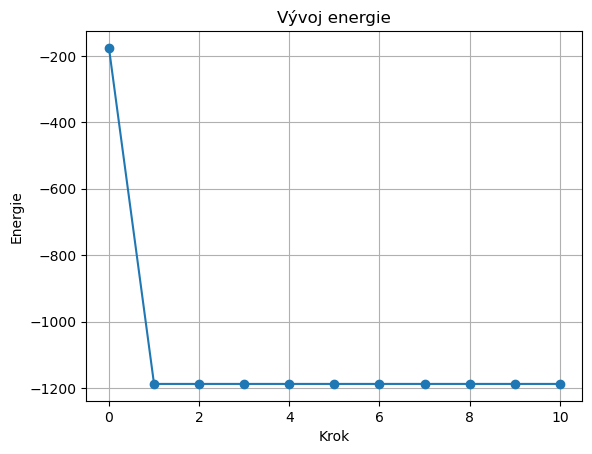

Animace uložena jako asyncO.gif


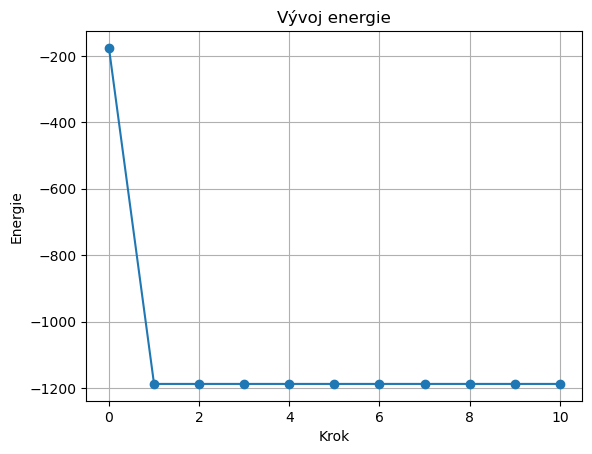

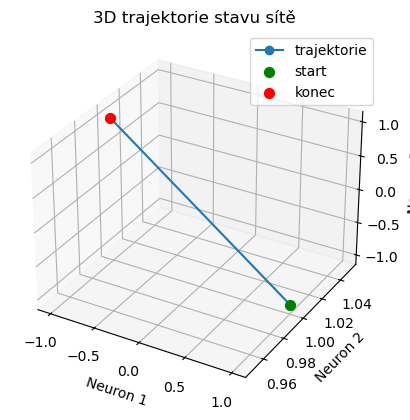

In [31]:
# Generování a trénování
patterns = generate_patterns_7x7()
vectorized = vectorize(patterns)
W = train_hopfield(vectorized)

# Zašuměný vstup
test_pattern = add_noise(vectorized[0], noise_level=0.3)

states_sync = animate_reconstruction(W, test_pattern, update_sync_step, steps=10, save_as="syncO.gif", collect_states=True, resolution=(7, 7))
# Spustíme animaci a získáme mezikroky
states = animate_reconstruction(W, test_pattern, update_async_step, steps=10, save_as="asyncO.gif", collect_states=True, resolution=(7, 7))

# Zobrazíme 3D trajektorii
plot_energy_trajectory(W, states)

Animace uložena jako syncO.gif


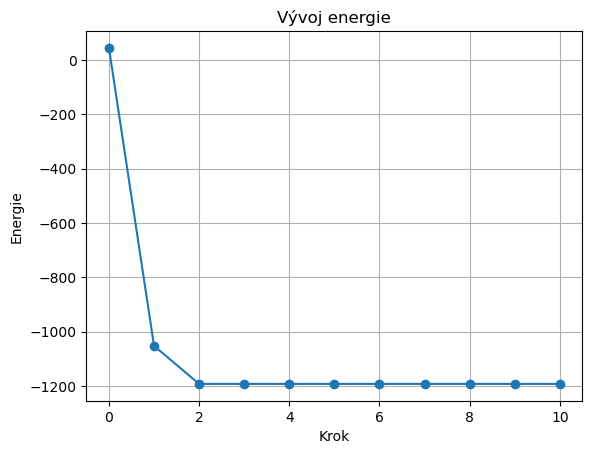

Animace uložena jako asyncO.gif


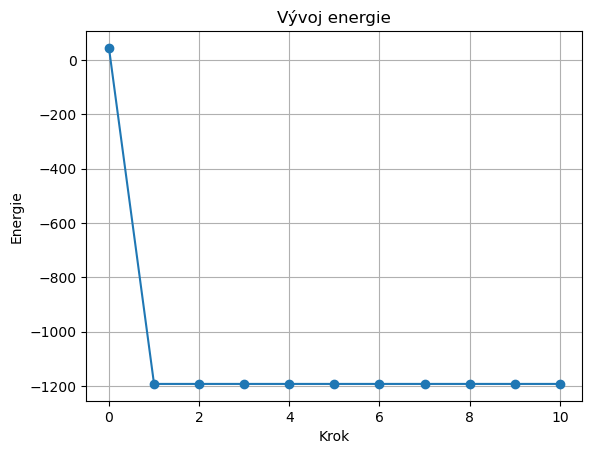

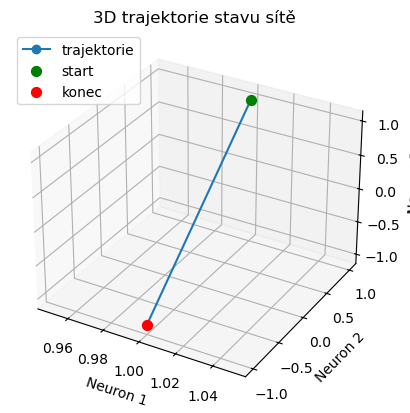

In [29]:
# Generování a trénování
patterns = generate_patterns_7x7()
vectorized = vectorize(patterns)
W = train_hopfield(vectorized)

# Zašuměný vstup
test_pattern = add_noise(vectorized[0], noise_level=0.5)

states_sync = animate_reconstruction(W, test_pattern, update_sync_step, steps=10, save_as="syncO.gif", collect_states=True, resolution=(7, 7))
# Spustíme animaci a získáme mezikroky
states = animate_reconstruction(W, test_pattern, update_async_step, steps=10, save_as="asyncO.gif", collect_states=True, resolution=(7, 7))

# Zobrazíme 3D trajektorii
plot_energy_trajectory(W, states)

Animace uložena jako syncA.gif


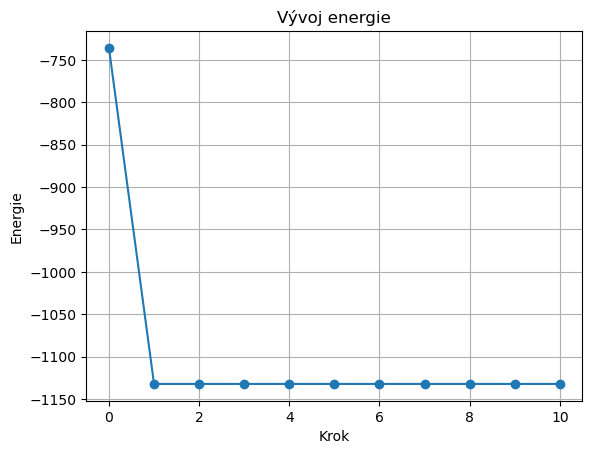

Animace uložena jako asyncA.gif


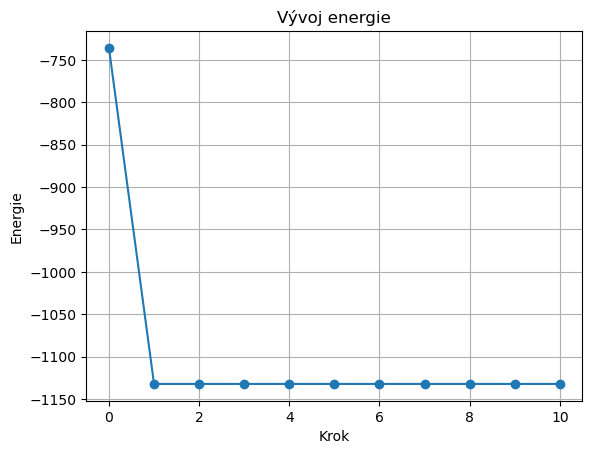

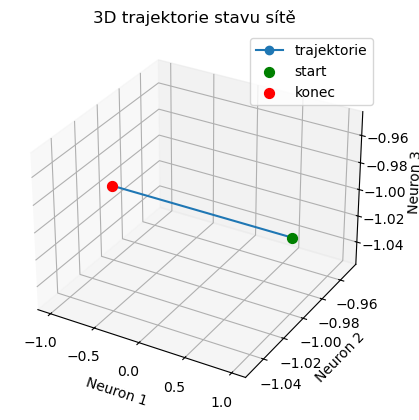

In [30]:
# Generování a trénování
patterns = generate_patterns_7x7()
vectorized = vectorize(patterns)
W = train_hopfield(vectorized)

# Zašuměný vstup
test_pattern = np.array([
        [1, -1, -1,  1, -1, -1, 1],
        [1, -1,  1, -1,  1, -1, 1],
        [1,  1, -1, -1, -1,  1, 1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 1, -1, -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1, -1, -1,  1]
    ])
test_pattern = test_pattern.flatten()

states_sync = animate_reconstruction(W, test_pattern, update_sync_step, steps=10, save_as="syncA.gif", collect_states=True, resolution=(7, 7))
# Spustíme animaci a získáme mezikroky
states = animate_reconstruction(W, test_pattern, update_async_step, steps=10, save_as="asyncA.gif", collect_states=True, resolution=(7, 7))

# Zobrazíme 3D trajektorii
plot_energy_trajectory(W, states)